In [24]:
%load_ext autoreload
import random
from openff.toolkit.topology import Molecule
import h5py
import numpy as onp
import jax
import jax.numpy as jnp
import jax_md
import espalomax as esp
from concurrent import futures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from jax import numpy as jnp
from openff.toolkit.topology import Molecule
from openff.toolkit.typing.engines.smirnoff import ForceField
smiles = "CC"
molecule = Molecule.from_smiles(smiles)
molecule.assign_partial_charges("zeros")
forcefield = ForceField("openff_unconstrained-2.0.0.offxml")
system = forcefield.create_openmm_system(
    molecule.to_topology(),
    charge_from_molecules=[molecule],
)

from jax_md.mm_utils import parameters_from_openmm_system
parameters = parameters_from_openmm_system(system)
from jax_md.mm import PeriodicTorsionParameters
parameters = parameters._replace(
        periodic_torsion_parameters=PeriodicTorsionParameters(
        particles=parameters.periodic_torsion_parameters.particles,
        amplitude=jnp.zeros_like(parameters.periodic_torsion_parameters.amplitude),
        periodicity=parameters.periodic_torsion_parameters.periodicity,
        phase=parameters.periodic_torsion_parameters.phase,
    ),
)
    

molecule.generate_conformers()
coordinate = molecule.conformers[0]._value * 0.1
coordinate = jnp.array(coordinate)

from jax_md import space
displacement_fn, shift_fn = space.free()

from jax_md.mm import mm_energy_fn
energy_fn, _ = mm_energy_fn(
    displacement_fn, default_mm_parameters=parameters,
)

In [47]:
from jax_md import simulate
temperature = 1.0
dt = 1e-3
init, update = simulate.nvt_nose_hoover(energy_fn, shift_fn, dt, temperature)
state = init(jax.random.PRNGKey(2666), coordinate)
update = jax.jit(update)

In [48]:
traj = []
for _ in range(1000):
    state = update(state)
    traj.append(state.position)
traj = jnp.stack(traj) 
u = jax.vmap(energy_fn)(traj)
u = u - esp.mm.get_nonbonded_energy(molecule, traj)

In [49]:
from openmm import unit
for _traj in traj:
    molecule.add_conformer(_traj * unit.nanometer)
molecule.visualize(backend="nglview")

NGLWidget(max_frame=1000)

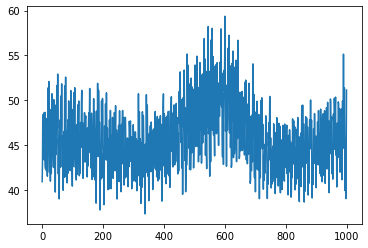

In [50]:
from matplotlib import pyplot as plt
plt.plot(u)

In [43]:
model = esp.nn.Parametrization(
    representation=esp.nn.GraphAttentionNetwork(128, 3),
    janossy_pooling=esp.nn.JanossyPooling(128, 4),
)

In [44]:
g = esp.Graph.from_openff_molecule(molecule)

/Users/wangy1/Documents/GitHub/espalomax/espalomax/openff_utils.py:66: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(molecule.to_networkx()).todense()
/Users/wangy1/Documents/GitHub/espalomax/espalomax/openff_utils.py:81: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(molecule.to_networkx()).todense()


In [45]:
def get_loss(nn_params, g, x, u):
    ff_params = model.apply(nn_params, g)
    u_hat = esp.mm.get_energy(ff_params, x, terms=["bond", "angle"])
    u_hat = u_hat - u_hat.mean()
    u = u - u.mean()
    return ((u - u_hat) ** 2).mean()

# @jax.jit
def step(state, g, x, u):
    nn_params = state.params
    grads = jax.grad(get_loss)(nn_params, g, x, u)
    state = state.apply_gradients(grads=grads)
    return state

import optax
optimizer = optax.chain(
    optax.adam(learning_rate=1e-3),
)

nn_params = model.init(jax.random.PRNGKey(2667), g)
from flax.training.train_state import TrainState
from flax.training.checkpoints import save_checkpoint
state = TrainState.create(
     apply_fn=model.apply, params=nn_params, tx=optimizer,
)

/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


In [35]:
import tqdm
import random
for idx_batch in range(10000):
        state = step(state, g, traj, u)
        ff_params = model.apply(state.params, g)
        u_hat = esp.mm.get_energy(ff_params, traj, terms=["bond", "angle"])
        print(jnp.abs((u - u.mean()) - (u_hat - u_hat.mean())).mean())

5.023032366982931
3.069339759598542
4.018579432814811
4.556912568879609
3.6831981192687433
3.016573083019567
3.6314541251974743
4.073659614230427
3.503139312236066
3.0308178998398727
3.1426072404581484
3.5235769343504693
3.521979112111777
3.187884293650629
2.978736700903367
3.0736586289773538
3.2867190435747218
3.2903873729928117
3.133579476034495
2.9927143772048295
2.9751527851795863
3.1050480039207407
3.1497894837606353
3.1056818507554156
3.0011893188632786
2.9564464786914386
3.0102033666899506
3.0574724983521557
3.0680774234106813
3.0253339870382074
2.97688293213681
2.9555553302186457
2.9842455071280183
3.012131541652999
3.0068063260268065
2.9790410920701134
2.9496076187465423
2.96186980776226
2.9850231873216644
3.0000481221347175
2.984846471374023
2.9612928949534334
2.9477840364402073
2.959109674166806
2.9692567255071998
2.967836107215489
2.957810519120433
2.949688601353346
2.9537212903029886
2.961410845994583
2.966286271033391
2.9628096165358686
2.954767370515452
2.947407897645118

KeyboardInterrupt: 

In [40]:
from sklearn.metrics import r2_score
r2_score(u - u.mean(), u_hat - u_hat.mean())

0.005511434039318641

In [41]:
jnp.abs((u - u.mean()) - (u_hat - u_hat.mean()))

DeviceArray([4.91243049e+00, 2.69418529e+00, 2.96708816e+00,
             4.30389716e-01, 1.38860151e+00, 3.67094824e+00,
             3.28582614e+00, 1.40334192e+00, 1.50971669e+00,
             3.77726742e+00, 2.36928186e+00, 3.03034352e+00,
             2.51418564e+00, 6.30673271e-01, 3.34566922e+00,
             2.36754961e+00, 1.22751075e+00, 4.29853325e+00,
             1.53381191e+00, 4.65669534e+00, 1.72849980e+00,
             1.06266298e+00, 5.58936579e+00, 2.46120815e+00,
             4.42237844e+00, 2.67385572e+00, 1.42222647e+00,
             5.16964733e+00, 2.09200188e+00, 1.52766701e+00,
             4.56236751e+00, 1.47914021e+00, 5.26068819e+00,
             1.43544759e+00, 1.04945107e+00, 3.31691223e+00,
             1.52936434e+00, 3.36367683e+00, 3.85884542e+00,
             2.36730666e+00, 3.43155087e+00, 3.61946371e-01,
             3.78914588e-01, 6.20680424e+00, 1.90496406e+00,
             3.00926060e+00, 2.75158734e+00, 1.03460749e+00,
             4.89512433e

In [21]:
ff_params = model.apply(state.params, g)
u_hat = esp.mm.get_energy(ff_params, traj)

/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


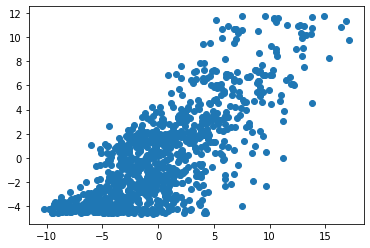

In [22]:
from matplotlib import pyplot as plt
plt.scatter(u - u.mean(), u_hat - u_hat.mean())

In [26]:
u

DeviceArray([51.14971002, 53.20641815, 58.65508915, 55.93590118,
             53.8448056 , 58.45810547, 57.71904092, 52.73083828,
             55.22161097, 57.19404704, 50.81053293, 49.62151839,
             54.60440301, 50.96165506, 47.57671614, 52.49493941,
             50.65169902, 44.40021008, 49.73743225, 52.73985174,
             45.88303061, 47.88964637, 52.07368271, 43.97335619,
             42.05011277, 49.40725453, 45.28886703, 41.59320083,
             49.39189232, 49.19078659, 43.21428094, 49.33334865,
             52.98808751, 46.35267062, 47.56077969, 52.77554054,
             48.67977969, 48.08655818, 56.25241578, 54.95433897,
             49.31663978, 52.9149439 , 52.79619728, 46.77106315,
             51.31100243, 56.45247049, 51.81012686, 54.10689021,
             60.07998455, 56.33281424, 55.73429518, 61.18774777,
             56.29644428, 51.18557324, 55.18496502, 53.71070882,
             49.94997655, 55.51750436, 57.2757464 , 52.02170373,
             54.68287411,

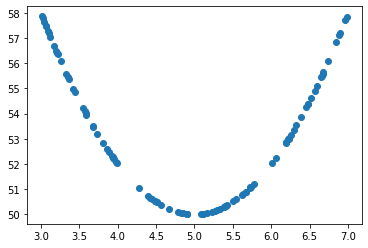

In [22]:
from matplotlib import pyplot as plt
u_hat = esp.mm.get_energy(ff_params, traj, terms=["bond"])
plt.scatter(traj[:, -1, 0], u_hat)

In [34]:
ff_params["bond"]["coefficients"] = jnp.zeros_like(ff_params["bond"]["coefficients"])

In [26]:
ff_params["bond"]["coefficients"]

DeviceArray([[3.8633392e-05, 3.8633392e-05]], dtype=float32)